In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from tqdm import tqdm
from scipy import ndimage


In [2]:
import torch.nn.functional as F
import torch as tc
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from helpers_img import *
from NeuralNets import *
from training_NN import *
from preprocessing import *

In [ ]:
tc.cuda.empty_cache()

# Valerio inizia da qui

In [ ]:
a = [1,2]
b=[*a*4]
print(b)

In [3]:
class DatasetSimpleNet(Dataset):
    def __init__(self,root_dir, nb_boot=0, do_flip=False, do_rotation=False,do_train=False):
        self.image_dir = root_dir + "images/"
        self.files = os.listdir(self.image_dir)
        self.gt_dir = root_dir + "groundtruth/"
        self.rot_len=0
        self.flip_len=0
        self.train = do_train
        self.initial_len=len(self.files)
        # rotation
        if do_rotation:
            self.rot_len= len(self.files)
            self.files = [*self.files*4]
        #flip 
        if do_flip:
            self.flip_len=len(self.files)
            self.files= [*self.files*2]
        if nb_boot > 0:
            if nb_boot<len(self.files):
                self.bootstrap_dataset = np.random.choice(np.arange(len(self.files)), size =nb_boot,
                                                          replace = False)
            else :
                self.bootstrap_dataset = np.random.choice(np.arange(len(self.files)), size =nb_boot,
                                                          replace = True)
        else :
            self.bootstrap_dataset = np.arange(len(self.files))
        self.bootstrap_dataset = np.array(self.bootstrap_dataset)
        self.binary_vector = np.ones(len(self.files))
        
        self.binary_vector[self.bootstrap_dataset]=0
                
        
    def __len__(self):
        return self.bootstrap_dataset.shape[0]
    
    def __getitem__(self,index):
        ind = self.bootstrap_dataset[index]
        image = [load_image(self.image_dir + self.files[ind])]
        gt_image = [load_image(self.gt_dir + self.files[ind])]
        if self.rot_len>0:
            image,gt_image = rotation(image,gt_image)
        if self.flip_len>0:
            image,gt_image = flip(image,gt_image)
        
        i = index//self.initial_len
        image,gt_image = image[i],gt_image[i]
        w,h=16,16
        train_sub_images = [img_crop(image, w, h)]
        train_mask_label = [img_crop(gt_image,w,h)]
        train_mask_label = from_mask_to_vector(train_mask_label,0.3)
        train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
        mean = train_sub_images.mean()
        std = train_sub_images.std()
        train_sub_images = (train_sub_images-mean)/std
        if self.train:
            train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
            for l in range(10):
                new_indices= np.random.permutation(len(train_mask_label))
                train_sub_images=train_sub_images[new_indices]
                train_mask_label=train_mask_label[new_indices]
        return train_sub_images, 1*train_mask_label

In [ ]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
N = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(N) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(N)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(N) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(N)]
print(files[0])

#n = 85 # Only use 85 images for training

In [ ]:
# augment the dataset adding rotated images
imgs, gt_imgs = rotation(imgs, gt_imgs)
print('Total number of imgages: '+str(len(imgs)))

In [ ]:
def bootstrap_images(imgs, gt_imgs,size,number):
    '''This function returns a list of list. Each element of the "external" list is a list of randomly 
    sampled images with replacement'''
    
    new_imgs=[]
    new_gt_imgs=[]
    array = np.arange(len(imgs))
    matrix= np.zeros((len(imgs),number))
    for k in range(number):
        b = np.random.choice(array, size, replace=True)
        list_temp_imgs = [imgs[i] for i in b]
        list_temp_gt_imgs = [gt_imgs[i] for i in b]
        new_imgs.append(list_temp_imgs)
        new_gt_imgs.append(list_temp_gt_imgs)
        matrix[b,k]=1
    
    return new_imgs,new_gt_imgs,matrix

In [ ]:
#? np.ndarray

In [4]:
def train_SimpleNet(dataset,lr, max_epochs, mini_batch_size, dropout):
    ''' Train a simple net'''
    
    model = SimpleNet(dropout)
    
    train_model_Adam( model, dataset, max_epochs, lr, mini_batch_size)
    
    return model



In [5]:
def train_model_Adam( model, dataset, max_epochs, lr, mini_batch_size, threshold=0.01):
    '''train the Neural Net using Adam as optimizer and an MSE loss'''
    #optimizer=tc.optim.SGD(model.parameters(),lr)
    train_loader = DataLoader(dataset,batch_size=mini_batch_size)
    optimizer=tc.optim.Adam(model.parameters(),lr)
    criterion= tc.nn.MSELoss()
    losses=[]
    if tc.cuda.is_available():
        model.cuda()
        
    
    for i in tqdm(range(max_epochs)):
        model.is_training=True
        model.train()
    
        for train_data,label in train_loader:
            train_data = train_data.view(-1,3,16,16)
            label = label.type(tc.FloatTensor).view(-1,1)
            if tc.cuda.is_available():
                train_data = train_data.cuda()
                label = label.cuda()
           
            output= model(train_data)
            #print(output,tc.LongTensor(np.array([1*label[i:i+mini_batch_size]]).reshape(-1,1)))
            loss= criterion(output,label.reshape(-1,1))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss)
        # compute training error
        '''
        model.is_training=False
        model.eval()
        test = model(train_data)
        test = test.cpu()
        prediction= test[:]>0.5
        
        prediction= 1*(prediction.numpy()[:] != label.reshape(-1,1)[:])
        
        training_error = np.sum(prediction)/len(prediction)
        training_errors.append(training_error*100)
        if training_error< threshold:
            break
        
    '''
    plt.figure()
    plt.plot(np.arange(max_epochs)+1,losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
    model.cpu()    
    

In [8]:
def bagging_NN(root_dir, percentage_train_data, nb_model, w, h, lr, max_epochs, mini_batch_size, dropout):
    nb_data = int( 800*percentage_train_data )
    list_dataset = [DatasetSimpleNet(root_dir, nb_boot=nb_data, do_flip=True, do_rotation=True) for l in range(nb_model)]
    models = []
    for i in range(nb_model):
        model=train_SimpleNet(list_dataset[i], lr, max_epochs, mini_batch_size, dropout)
        models.append(model)
        print('model '+str(i)+' trained')
        
    # the data matrix has 1 in position n,j if the nth image was not used in jth
    # model training.
    
    # compute F1 error
    
        
    
    F1_error=0
    not_testable_img=0
    predictions=[]
    total_dataset = DatasetSimpleNet(root_dir, nb_boot=0, do_flip=False, do_rotation=False, 
                                    do_train=False)
    #test_loader = DataLoader(dataset)
    binary_matrix = np.zeros((800,nb_model))
    for i,dataset in enumerate(list_dataset):
        binary_matrix[:,i] = dataset.binary_vector
    for i in tqdm(range(800)):        
        if binary_matrix[i,:].sum()>0:
            test,label = total_dataset.__getitem__(i)
            ind=np.where(binary_matrix[i,:])[0]
            predictions=np.array([models[k](test).detach().numpy() for k in ind])
            predictions = ((predictions.mean(0)[:] >0.5)*1).reshape(-1,)
            mask_test = label_to_img(400, 400, w, h, predictions)
            label = label_to_img(400, 400, w, h, label)
            F1_error += calcul_F1(label, mask_test)
        else:
            not_testable_img+=1
    
    try:
        F1_error= F1_error/(nb_data-not_testable_img)
    except:
        F1_error=0
    return models, F1_error
    

  0%|          | 0/15 [00:00<?, ?it/s]

cuda is available


100%|██████████| 15/15 [02:31<00:00, 10.14s/it]


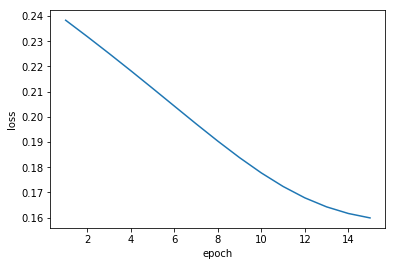

  0%|          | 0/15 [00:00<?, ?it/s]

model 0 trained


100%|██████████| 15/15 [02:32<00:00, 10.20s/it]


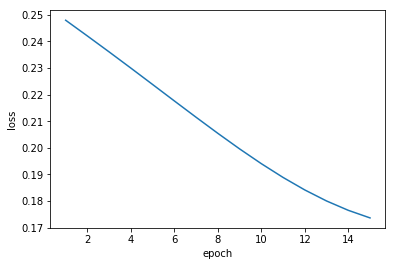

  0%|          | 0/15 [00:00<?, ?it/s]

model 1 trained


100%|██████████| 15/15 [02:33<00:00, 10.23s/it]


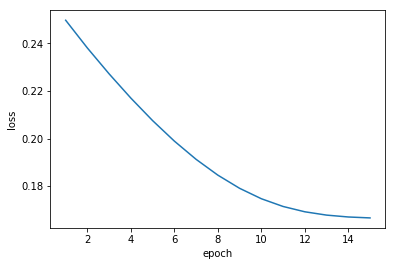

  0%|          | 0/15 [00:00<?, ?it/s]

model 2 trained


100%|██████████| 15/15 [02:39<00:00, 10.37s/it]


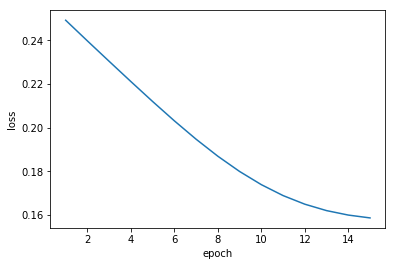

  0%|          | 0/15 [00:00<?, ?it/s]

model 3 trained


100%|██████████| 15/15 [02:34<00:00, 10.31s/it]


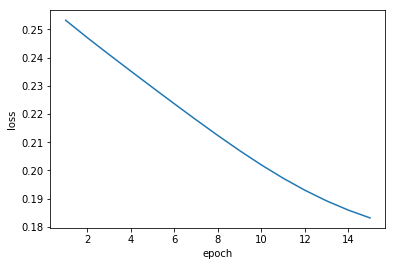

  0%|          | 0/15 [00:00<?, ?it/s]

model 4 trained


100%|██████████| 15/15 [02:35<00:00, 10.45s/it]


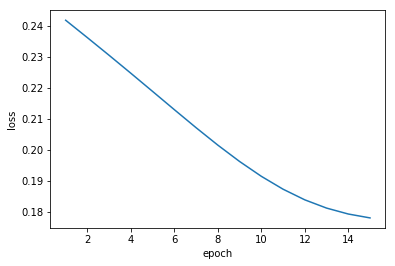

  0%|          | 0/15 [00:00<?, ?it/s]

model 5 trained


100%|██████████| 15/15 [02:42<00:00, 10.41s/it]


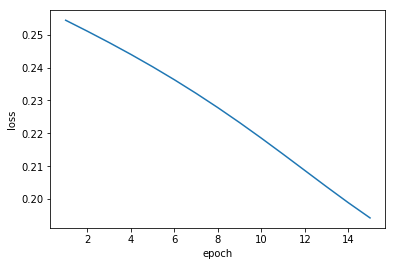

  0%|          | 0/15 [00:00<?, ?it/s]

model 6 trained


100%|██████████| 15/15 [02:41<00:00, 10.45s/it]


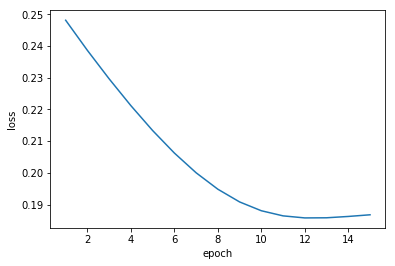

  0%|          | 0/15 [00:00<?, ?it/s]

model 7 trained


100%|██████████| 15/15 [02:50<00:00, 11.58s/it]


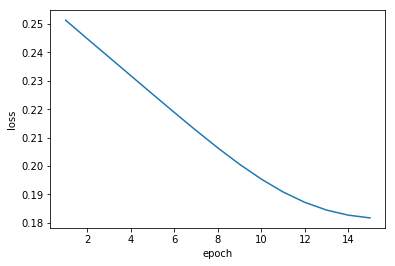

  0%|          | 0/15 [00:00<?, ?it/s]

model 8 trained


100%|██████████| 15/15 [02:43<00:00,  9.90s/it]


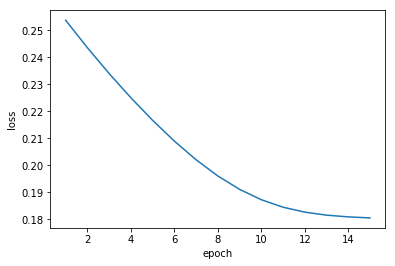

  0%|          | 0/800 [00:00<?, ?it/s]

model 9 trained


  0%|          | 1/800 [00:00<07:02,  1.89it/s]

Something goes wrong...


  0%|          | 2/800 [00:01<07:09,  1.86it/s]

Something goes wrong...


  0%|          | 3/800 [00:01<07:14,  1.83it/s]

Something goes wrong...


  0%|          | 4/800 [00:02<07:01,  1.89it/s]

Something goes wrong...


  1%|          | 5/800 [00:02<06:45,  1.96it/s]

Something goes wrong...


  1%|          | 6/800 [00:03<07:00,  1.89it/s]

Something goes wrong...


  1%|          | 7/800 [00:03<07:00,  1.89it/s]

Something goes wrong...


  1%|          | 8/800 [00:04<06:55,  1.91it/s]

Something goes wrong...


  1%|          | 9/800 [00:04<06:53,  1.91it/s]

Something goes wrong...


  1%|▏         | 10/800 [00:05<06:58,  1.89it/s]

Something goes wrong...


  1%|▏         | 11/800 [00:05<06:44,  1.95it/s]

Something goes wrong...


  2%|▏         | 12/800 [00:06<06:38,  1.98it/s]

Something goes wrong...


  2%|▏         | 13/800 [00:06<06:35,  1.99it/s]

Something goes wrong...


  2%|▏         | 14/800 [00:07<06:30,  2.01it/s]

Something goes wrong...


  2%|▏         | 15/800 [00:07<06:39,  1.97it/s]

Something goes wrong...


  2%|▏         | 16/800 [00:08<06:42,  1.95it/s]

Something goes wrong...


  2%|▏         | 17/800 [00:08<06:33,  1.99it/s]

Something goes wrong...


  2%|▏         | 18/800 [00:09<06:40,  1.95it/s]

Something goes wrong...


  2%|▏         | 19/800 [00:09<06:41,  1.94it/s]

Something goes wrong...


  2%|▎         | 20/800 [00:10<06:38,  1.95it/s]

Something goes wrong...


  3%|▎         | 21/800 [00:10<06:44,  1.92it/s]

Something goes wrong...


  3%|▎         | 22/800 [00:11<06:39,  1.95it/s]

Something goes wrong...


  3%|▎         | 23/800 [00:11<06:46,  1.91it/s]

Something goes wrong...


  3%|▎         | 24/800 [00:12<06:40,  1.94it/s]

Something goes wrong...


  3%|▎         | 25/800 [00:12<06:28,  2.00it/s]

Something goes wrong...


  3%|▎         | 26/800 [00:13<06:34,  1.96it/s]

Something goes wrong...


  3%|▎         | 27/800 [00:13<06:34,  1.96it/s]

Something goes wrong...


  4%|▎         | 28/800 [00:14<06:39,  1.93it/s]

Something goes wrong...


  4%|▎         | 29/800 [00:14<06:28,  1.98it/s]

Something goes wrong...


  4%|▍         | 30/800 [00:15<06:42,  1.91it/s]

Something goes wrong...


  4%|▍         | 31/800 [00:16<06:46,  1.89it/s]

Something goes wrong...


  4%|▍         | 32/800 [00:16<06:41,  1.92it/s]

Something goes wrong...


  4%|▍         | 33/800 [00:17<06:26,  1.99it/s]

Something goes wrong...


  4%|▍         | 34/800 [00:17<06:23,  2.00it/s]

Something goes wrong...


  4%|▍         | 35/800 [00:18<06:34,  1.94it/s]

Something goes wrong...


  4%|▍         | 36/800 [00:18<06:35,  1.93it/s]

Something goes wrong...


  5%|▍         | 37/800 [00:19<06:56,  1.83it/s]

Something goes wrong...


  5%|▍         | 38/800 [00:19<06:52,  1.85it/s]

Something goes wrong...


  5%|▍         | 39/800 [00:20<06:30,  1.95it/s]

Something goes wrong...


  5%|▌         | 40/800 [00:20<06:35,  1.92it/s]

Something goes wrong...


  5%|▌         | 41/800 [00:21<06:20,  1.99it/s]

Something goes wrong...


  5%|▌         | 42/800 [00:21<06:29,  1.95it/s]

Something goes wrong...


  5%|▌         | 43/800 [00:22<06:28,  1.95it/s]

Something goes wrong...


  6%|▌         | 44/800 [00:22<06:31,  1.93it/s]

Something goes wrong...


  6%|▌         | 45/800 [00:23<06:36,  1.90it/s]

Something goes wrong...


  6%|▌         | 46/800 [00:23<06:44,  1.87it/s]

Something goes wrong...


  6%|▌         | 47/800 [00:24<06:30,  1.93it/s]

Something goes wrong...


  6%|▌         | 48/800 [00:24<06:42,  1.87it/s]

Something goes wrong...


  6%|▌         | 49/800 [00:25<06:34,  1.90it/s]

Something goes wrong...


  6%|▋         | 50/800 [00:25<06:24,  1.95it/s]

Something goes wrong...


  6%|▋         | 51/800 [00:26<06:36,  1.89it/s]

Something goes wrong...


  6%|▋         | 52/800 [00:26<06:36,  1.89it/s]

Something goes wrong...


  7%|▋         | 53/800 [00:27<06:40,  1.87it/s]

Something goes wrong...


  7%|▋         | 54/800 [00:28<06:41,  1.86it/s]

Something goes wrong...


  7%|▋         | 55/800 [00:28<06:25,  1.93it/s]

Something goes wrong...


  7%|▋         | 56/800 [00:29<06:21,  1.95it/s]

Something goes wrong...


  7%|▋         | 57/800 [00:29<06:20,  1.95it/s]

Something goes wrong...


  7%|▋         | 58/800 [00:30<06:31,  1.90it/s]

Something goes wrong...


  7%|▋         | 59/800 [00:30<06:41,  1.85it/s]

Something goes wrong...


  8%|▊         | 60/800 [00:31<06:36,  1.87it/s]

Something goes wrong...


  8%|▊         | 61/800 [00:31<06:38,  1.86it/s]

Something goes wrong...


  8%|▊         | 62/800 [00:32<06:29,  1.89it/s]

Something goes wrong...


  8%|▊         | 63/800 [00:32<06:32,  1.88it/s]

Something goes wrong...


  8%|▊         | 64/800 [00:33<06:32,  1.88it/s]

Something goes wrong...


  8%|▊         | 65/800 [00:33<06:33,  1.87it/s]

Something goes wrong...


  8%|▊         | 66/800 [00:34<06:29,  1.88it/s]

Something goes wrong...


  8%|▊         | 67/800 [00:34<06:24,  1.91it/s]

Something goes wrong...


  8%|▊         | 68/800 [00:35<06:34,  1.86it/s]

Something goes wrong...


  9%|▊         | 69/800 [00:35<06:22,  1.91it/s]

Something goes wrong...


  9%|▉         | 70/800 [00:36<06:15,  1.95it/s]

Something goes wrong...


  9%|▉         | 71/800 [00:36<06:12,  1.96it/s]

Something goes wrong...


  9%|▉         | 72/800 [00:37<06:24,  1.89it/s]

Something goes wrong...


  9%|▉         | 73/800 [00:38<06:19,  1.91it/s]

Something goes wrong...


  9%|▉         | 74/800 [00:38<06:27,  1.87it/s]

Something goes wrong...


  9%|▉         | 75/800 [00:39<06:42,  1.80it/s]

Something goes wrong...


 10%|▉         | 76/800 [00:39<06:47,  1.78it/s]

Something goes wrong...


 10%|▉         | 77/800 [00:40<06:43,  1.79it/s]

Something goes wrong...


 10%|▉         | 78/800 [00:40<06:37,  1.82it/s]

Something goes wrong...


 10%|▉         | 79/800 [00:41<06:48,  1.77it/s]

Something goes wrong...


 10%|█         | 80/800 [00:41<06:36,  1.82it/s]

Something goes wrong...


 10%|█         | 81/800 [00:42<06:34,  1.82it/s]

Something goes wrong...


 10%|█         | 82/800 [00:43<06:31,  1.83it/s]

Something goes wrong...


 10%|█         | 83/800 [00:43<06:16,  1.90it/s]

Something goes wrong...


 10%|█         | 84/800 [00:44<06:25,  1.86it/s]

Something goes wrong...


 11%|█         | 85/800 [00:44<06:29,  1.83it/s]

Something goes wrong...


 11%|█         | 86/800 [00:45<06:27,  1.84it/s]

Something goes wrong...


 11%|█         | 87/800 [00:45<06:08,  1.94it/s]

Something goes wrong...


 11%|█         | 88/800 [00:46<05:54,  2.01it/s]

Something goes wrong...


 11%|█         | 89/800 [00:46<05:56,  2.00it/s]

Something goes wrong...


 11%|█▏        | 90/800 [00:47<06:00,  1.97it/s]

Something goes wrong...


 11%|█▏        | 91/800 [00:47<05:58,  1.98it/s]

Something goes wrong...


 12%|█▏        | 92/800 [00:48<06:00,  1.97it/s]

Something goes wrong...


 12%|█▏        | 93/800 [00:48<06:02,  1.95it/s]

Something goes wrong...


 12%|█▏        | 94/800 [00:49<06:10,  1.90it/s]

Something goes wrong...


 12%|█▏        | 95/800 [00:49<06:13,  1.89it/s]

Something goes wrong...


 12%|█▏        | 96/800 [00:50<06:12,  1.89it/s]

Something goes wrong...


 12%|█▏        | 97/800 [00:50<06:17,  1.86it/s]

Something goes wrong...


 12%|█▏        | 98/800 [00:51<06:03,  1.93it/s]

Something goes wrong...


 12%|█▏        | 99/800 [00:51<06:09,  1.89it/s]

Something goes wrong...


 12%|█▎        | 100/800 [00:52<06:08,  1.90it/s]

Something goes wrong...


IndexError: index 100 is out of bounds for axis 0 with size 100

In [9]:
# valerio modifica questo
percentage_train_data=0.05
nb_model=10
w=16
h=16
lr=1e-4
max_epochs=15
root_dir = 'training/'
mini_batch_size=20
dropout=0
np.random.seed(52)
if tc.cuda.is_available():
    print('cuda is available')
models, F1_error= bagging_NN(root_dir, percentage_train_data, nb_model, w, h, lr, max_epochs, mini_batch_size, dropout)

In [29]:
print(F1_error)

0


In [7]:
tc.cuda.is_available()

True

In [ ]:
test_img = imgs[0]
mask= gt_imgs[0]
test_img = [img_crop(test_img, 16,16)]
test_img = transform_subIMG_to_Tensor(test_img)
mean=test_img.mean()
std= test_img.std()
test_img = (test_img-mean)/std
result=np.zeros((test_img.size(0),))
for model in models:
    result += model(test_img).detach_().numpy().reshape(-1,)

result = result / len(models)
result = (result > 0.5)*1


image = imgs[0]

mask_res = label_to_img(400, 400, 16, 16, result)
image_plot = make_img_overlay(image, mask_res)
plt.figure(figsize=(10, 10))
plt.imshow(image_plot)
    

In [ ]:
def compute_test_error(test_dataset, test_label, nb_patches, model):
    ''' compute the F1 error made during road segmentation. 
    Exemple: for a 16*16 patch we have that nb_patches=625'''
    model.is_train=False
    mean=test_dataset.mean()
    std= test_dataset.std()
    test_dataset = (test_dataset-mean)/std
    test_output = model(test_dataset)
    w = int(400/np.sqrt(nb_patches))
    F1_error=np.zeros(int(test_dataset.size(0)/nb_patches))
    for i in range(int(test_dataset.size(0)/nb_patches)):
        mask = test_output.narrow(0,i*nb_patches, nb_patches)
        mask = mask.detach().numpy()[:]>0.5
        mask = label_to_img(400, 400, w, w, mask)
        F1_error[i] = calcul_F1(test_label[i], mask)
    plt.figure()
    plt.plot(np.arange(int(test_dataset.size(0)/nb_patches))+1,F1_error)
    plt.xlabel('image')
    plt.ylabel('F1_error')
    F1_mean= np.mean(F1_error)
    return F1_mean

In [ ]:
def print_image_test(test_image, models):
    ''' take a 608 * 608 image'''
    image_original = test_image
    test_image = img_crop(test_image,16,16)
    test_image = transform_subIMG_to_Tensor([test_image])
    mean=test_image.mean()
    std= test_image.std()
    test_image = (test_image-mean)/std
    predictions=[]
    for model in models:
        model.eval()
        predictions.append(model(test_image).detach().numpy().reshape(-1,))
    
    predictions = np.array(predictions).mean(0)
    predictions = predictions > 0.5
    # add there the postprocessing
    
    ###############################################
    predictions=label_to_img(608, 608, 16, 16, predictions)
    
    image = make_img_overlay(image_original, predictions)
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)

In [ ]:
# Loaded a set of images
root_dir_test = "test_set_images/"
imgs_test = []
for l in range(1,51):
    dir_test = root_dir_test + 'test_'+str(l)+'/'
    files_test = os.listdir(dir_test)
    img_test = load_image(dir_test + files_test[0])
    imgs_test.append(img_test)

In [ ]:
print_image_test(imgs_test[9], models)

In [ ]:
# Post processing

In [ ]:
def complete_lines(label,threshold):
    ''' The function controls for each non-road square its neighbors. 
        If they are classified as ROAD with a certain pattern, the considered square is labeled as ROAD.
        
        INPUT: List of patches, Vector of label (SAME ORDER)
        OUTPUT: New patches, New Vector of label'''
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # Column with less then 4 zeros are considered as ROAD
    #threshold = 16
    matrix_label[:,np.where(matrix_label.sum(axis=0)>=threshold)[0]] = 1
  
    
    # Rows with less then 4 zeros are considered as ROAD
    #threshold = 16
    matrix_label[np.where(matrix_label.sum(axis=1)>=threshold)[0],:] = 1
  
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    return label

In [ ]:
new_label = complete_lines(result,16)

# DISPLAY THE IMAGE
mask_res = label_to_img(400, 400, 16, 16, new_label)
image_plot = make_img_overlay(image, mask_res)
plt.figure(figsize=(10, 10))
plt.imshow(image_plot)

In [ ]:
def remove_isolated_connected_component(label,size_min):
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # now identify the objects and remove those above a threshold
    Zlabeled,Nlabels = ndimage.measurements.label(matrix_label)
    label_size = [(Zlabeled == label).sum() for label in range(Nlabels + 1)]
    
    # now remove the labels
    for label,size in enumerate(label_size):
        if size < size_min:
            matrix_label[Zlabeled == label] = 0
    
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    
    return label


In [ ]:
new_label2 = remove_isolated_connected_component(new_label,9)

# DISPLAY THE IMAGE
mask_res = label_to_img(400, 400, 16, 16, new_label2)
image_plot = make_img_overlay(image, mask_res)
plt.figure(figsize=(10, 10))
plt.imshow(image_plot)

In [ ]:
def complete_lines_almostfull(label):
    ''' The function controls for each non-road square its neighbors. 
        If they are classified as ROAD with a certain pattern, the considered square is labeled as ROAD.
        
        INPUT: List of labels
        OUTPUT: New list of labels'''
    
    max_zeros = 3
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # Fix columns
    rows,columns = matrix_label.shape
    for column in range(columns):
        count = 0
        start = 0
        end = 0
        for row in range(rows):
            if (matrix_label[row,column] == 1) and (start ==0):
                start = 1
            elif (matrix_label[row,column] == 1) and (start ==1) and (count>0):
                end = 1
            elif (matrix_label[row,column] == 0) and (start ==1) and (end==0):
                count = count + 1
            
            if end ==1:
                if count < max_zeros:
                    matrix_label[row-count:row,column] = 1
                start = 1
                end = 0
                count = 0
    
    # Fix rows
    for row in range(rows):
        count = 0
        start = 0
        end = 0
        for column in range(columns):
            if (matrix_label[row,column] == 1) and (start ==0):
                start = 1
            elif (matrix_label[row,column] == 1) and (start ==1) and (count>0):
                end = 1
            elif (matrix_label[row,column] == 0) and (start ==1) and (end==0):
                count = count + 1
            
            if end ==1:
                if count < max_zeros:
                    matrix_label[row,column-count:column] = 1
                start = 1
                end = 0
                count = 0
    
    
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    
    return label

In [ ]:
#new_label3 = complete_lines_almostfull(new_label2)

# DISPLAY THE IMAGE
#mask_res = label_to_img(400, 400, 16, 16, new_label3)
#image_plot = make_img_overlay(image, mask_res)
#plt.figure(figsize=(10, 10))
#plt.imshow(image_plot)

In [ ]:
def clean_garbage_vert(label,max_distance):
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # Column with all one values
    full_columns = np.where(matrix_label.sum(axis=0) == 38)[0]
    for column in full_columns:   
        if (column < max_distance) and (matrix_label[:,column+1].sum(axis=0) < 38):
            count = matrix_label[:,column+1:column+max_distance+1].sum(axis=1)
            for k in range(count.shape[0]):
                if count[k] < max_distance:
                    matrix_label[k,column+1:column+max_distance] = 0
        
        elif (column > 38 - max_distance) and (matrix_label[:,column-1].sum(axis=0) < 38):
            count = matrix_label[:,column-max_distance:column].sum(axis=1)
            for k in range(count.shape[0]):
                if count[k] < max_distance:
                    matrix_label[k,column-max_distance:column] = 0
        
        elif (column >= max_distance) and (column <= 38 - max_distance):
            if matrix_label[:,column+1].sum(axis=0) < 38:
                count = matrix_label[:,column+1:column+max_distance+1].sum(axis=1)
                for k in range(count.shape[0]):
                    if count[k] < max_distance:
                        matrix_label[k,column+1:column+max_distance] = 0
        
            if matrix_label[:,column-1].sum(axis=0) < 38:            
                count = matrix_label[:,column-max_distance:column].sum(axis=1)
                for k in range(count.shape[0]):
                    if count[k] < max_distance:
                        matrix_label[k,column-max_distance:column] = 0
        
    # Rows with less then 4 zeros are considered as ROAD
    #threshold = 16
    #matrix_label[np.where(matrix_label.sum(axis=1)>=threshold)[0],:] = 1
  
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    return label    

In [ ]:
new_label4 = clean_garbage_vert(new_label2,3)

# DISPLAY THE IMAGE
mask_res = label_to_img(400, 400, 16, 16, new_label4)
image_plot = make_img_overlay(image, mask_res)
plt.figure(figsize=(10, 10))
plt.imshow(image_plot)

In [ ]:
def clean_garbage_hor(label,max_distance):
    
    # Create a matrix of label
    label = np.array(label)
    label_per_line = int(np.sqrt(label.shape))
    matrix_label = label.reshape((label_per_line, label_per_line),order='F')
    
    # Column with all one values
    full_rows = np.where(matrix_label.sum(axis=1) == 38)[0]
    for row in full_rows:   
        if (row < max_distance) and (matrix_label[row+1,:].sum() < 38):
            count = matrix_label[row+1:row+max_distance+1,:].sum(axis=0)
            for k in range(count.shape[0]):
                if count[k] < max_distance:
                    matrix_label[row+1:row+max_distance,k] = 0
        
        elif (row > 38 - max_distance) and (matrix_label[row-1,:].sum() < 38):
            count = matrix_label[row-max_distance:row,:].sum(axis=0)
            for k in range(count.shape[0]):
                if count[k] < max_distance:
                    matrix_label[row-max_distance:row,k] = 0
        
        elif (row >= max_distance) and (row <= 38 - max_distance):
            if matrix_label[row+1,:].sum() < 38:
                count = matrix_label[row+1:row+max_distance+1,:].sum(axis=0)
                for k in range(count.shape[0]):
                    if count[k] < max_distance:
                        matrix_label[row+1:row+max_distance,k] = 0
        
            if matrix_label[row-1,:].sum() < 38:            
                count = matrix_label[row-max_distance:row,:].sum(axis=0)
                for k in range(count.shape[0]):
                    if count[k] < max_distance:
                        matrix_label[row-max_distance:row,k] = 0
        
    # Rows with less then 4 zeros are considered as ROAD
    #threshold = 16
    #matrix_label[np.where(matrix_label.sum(axis=1)>=threshold)[0],:] = 1
  
    # Create the list
    list_label = (matrix_label.T).tolist()
    # Flatten the lists
    label = [y for x in list_label for y in x]
    return label 

In [ ]:
new_label5 = clean_garbage_hor(new_label4,3)

# DISPLAY THE IMAGE
mask_res = label_to_img(400, 400, 16, 16, new_label5)
image_plot = make_img_overlay(image, mask_res)
plt.figure(figsize=(10, 10))
plt.imshow(image_plot)

In [ ]:
# Create mask
prevision = label_to_img(400, 400, 16, 16, new_label5)
F1=calcul_F1(mask, prevision)

In [ ]:
print(F1)

# Valerio fermati qui

In [ ]:
def post_processing(label,threshold,size_min,verbarg,horbarg):
    label = complete_lines(label,threshold)
    label = remove_isolated_connected_component(label,size_min)
    label = clean_garbage_vert(label,verbarg)
    label = clean_garbage_hor(label,horbarg)
    label = remove_isolated_connected_component(label,size_min)
    return label

In [ ]:
def create_submission(test_data, models, w, h, name_file, prediction_training_dir, normalize=True):
    ''' the function takes as input the test data and the models used for prediction. 
    If a list of model is given, the prediction will be done with majority vote. 
    
    The function is written explicitly for prediction using SimpleNet model.
    
    test_data: list of images.
    
    models: list of models or single model
    
    w, h: width and high of the patches'''
    
    # from list to Tensor
    w_im, h_im,_ = test_data[0].shape
    test_data = [img_crop(test_data[k], w, h) for k in range(len(test_data))]
    
    test_data = transform_subIMG_to_Tensor(test_data)
    
    if normalize:
        
        test_data = (test_data-test_data.mean())/test_data.std()
    
    try :
        nb_models = len(models)
        prediction = [] 
        for i in range(nb_models):
            models[i].eval()
            prediction.append((models[i](test_data)).detach().numpy())
            
        prediction = np.array(prediction)
        prediction = (prediction.sum(0)/nb_models > 0.5)*1
    
    except:
        
        prediction = models(test_data).detach().numpy()
        
        prediction = 1*(prediction > 0.5)
     
    prediction = prediction.reshape(-1,)
    
    nb_patches = int(w_im*h_im/(w*h))
    nb_images =int(prediction.shape[0]/nb_patches)
    list_of_mask = [prediction[i*nb_patches:(i+1)*nb_patches ] for i in range(nb_images)]
    for k in range(len(list_of_mask)):
        list_of_mask[k] = post_processing(list_of_mask[k],32,9,3,3)
    # from patch to image
    list_of_masks=[label_to_img(w_im, h_im, w, h, list_of_mask[k]) for k in range(nb_images)]
    list_of_string_names = []
    for i,gt_image in enumerate(list_of_masks):
        Image.fromarray(gt_image).save(prediction_training_dir + "prediction_" + str(i) + ".png")
        list_of_string_names.append("prediction_" + str(i) + ".png")
    # create file submission
    masks_to_submission(name_file, *list_of_string_names)

In [ ]:
Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + str(i) + ".png")
oimg = get_prediction_with_overlay(train_data_filename, i)
oimg.save(prediction_training_dir + "overlay_" + str(i) + ".png") 

In [ ]:
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


if __name__ == '__main__':
    submission_filename = 'dummy_submission.csv'
    image_filenames = []
    for i in range(1, 51):
        image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
        image_filenames.append(image_filename)
    masks_to_submission(submission_filename, *image_filenames)


In [ ]:
# Loaded a set of images
root_dir_test = "test_set_images/"
imgs_test = []
for l in range(1,51):
    dir_test = root_dir_test + 'test_'+str(l)+'/'
    files_test = os.listdir(dir_test)
    img_test = load_image(dir_test + files_test[0])
    imgs_test.append(img_test)

In [ ]:
list_of_masks = create_submission(imgs_test, models, 16, 16, 'Submission_first', normalize=True)

In [ ]:
list_of_masks[0].dtype

In [ ]:
for k in range(len(list_of_masks)):
    name = 'image_' + str(k)
    my_df = pd.DataFrame(list_of_masks[k])
    my_df.to_csv(name+'.csv')

## PER DIEGO: ASSICURATI DI AVERE GLI EXCEL NELLA STESSA FOLDER DELLA CARTELLLA

## Valerio caro, LEVA VIA STA ROBACCIA

In [ ]:
import pandas as pd
result=[]
for k in range(50):
    df = pd.read_csv('image_'+str(k)+'.csv').iloc[:,1:]
    matrix = df.values
    result.append(matrix)


# RESULT: LISTA DI MATRICI 608 * 608

In [ ]:
result[0].shape

In [ ]:
import pandas as pd
df = pd.read_csv('image_'+str(0)+'.csv').iloc[:,1:]

In [ ]:
df

In [ ]:
matrix = df.values
matrix

In [ ]:
import pandas as pd
my_df = pd.DataFrame(list_of_masks[0])

In [ ]:
my_df

In [ ]:
n=90*3
N=len(imgs)
train_imgs=imgs[0:n]
train_mask=gt_imgs[0:n]
test_imgs=imgs[n:N]
test_mask = gt_imgs[n:N]


In [ ]:
temp=concatenate_images(train_imgs[3], train_mask[3])
plt.figure(figsize=(10, 10))
plt.imshow(temp)

In [ ]:
? tc.nn.Dropout

In [ ]:
print(len(train_mask))

In [ ]:
print(len(test_imgs),N-n)

In [ ]:
# prepare input data 
w=16
h=16
train_sub_images=[img_crop(train_imgs[i], w, h) for i in range(n)]
train_mask_label=[img_crop(train_mask[i],w,h) for i in range(n)]
train_mask_label=from_mask_to_vector(train_mask_label,0.3)
test_sub_images=[img_crop(test_imgs[i], w, h) for i in range(N-n)]
#test_mask_label=[img_crop(train_mask[n+i],w,h) for i in range(n)]
#test_mask_label=from_mask_to_vector(test_mask_label)


In [ ]:
print((1*train_mask_label).sum()/len(train_mask_label))

In [ ]:
print(len(train_sub_images[0]))

In [ ]:
train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
test_sub_images = transform_subIMG_to_Tensor(test_sub_images)

In [ ]:
# normalize data
mean = train_sub_images.mean()
std = train_sub_images.std()
train_sub_images = (train_sub_images-mean)/std
train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
#print(train_sub_images[-1]-train_sub_images[-2])
for l in range(n):
    new_indices= np.random.permutation(len(train_mask_label))
    train_sub_images=train_sub_images[new_indices]
    train_mask_label=train_mask_label[new_indices]
#print(train_sub_images[0]-train_sub_images[1])
#train_sub_images.requires_grad_(True)

In [ ]:
 ? tc.Tensor.narrow

In [ ]:
print(train_mask_label.sum()/len(train_mask_label))

In [ ]:
model = SimpleNet(0)
lr=1e-4
max_epochs=15
mini_batch_size=1

train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)

In [ ]:
print(tc.__version__)

In [ ]:
? tc.mean

In [ ]:
N1=625

In [ ]:
# print the result on a single image
#N1=int(train_sub_images.size(0)/n)
image_test= test_sub_images.narrow(0,43*N1,N1)
image_test=(image_test-mean)/std
mask_array=model(image_test)
#print(mask_array.max())
mask_list=mask_array[:]>0.5
mask_test = label_to_img(400, 400, 16, 16, mask_list)

In [ ]:
# compute F1 score
mask=gt_imgs[n]
#print(mask.sum())
print(calcul_F1(mask, mask_test))

In [ ]:
# overlap images

print_img = make_img_overlay(imgs[n+43], mask_test)
#print_img = make_img_overlay(imgs[n+43], gt_imgs[n+43])
plt.figure(figsize=(10, 10))
plt.imshow(print_img)

In [ ]:
def compute_test_error(test_dataset, test_label, nb_patches, model):
    ''' compute the F1 error made during road segmentation. 
    Exemple: for a 16*16 patch we have that nb_patches=625'''
    model.is_train=False
    mean=test_dataset.mean()
    std= test_dataset.std()
    test_dataset = (test_dataset-mean)/std
    test_output = model(test_dataset)
    w = int(400/np.sqrt(nb_patches))
    F1_error=np.zeros(int(test_dataset.size(0)/nb_patches))
    for i in range(int(test_dataset.size(0)/nb_patches)):
        mask = test_output.narrow(0,i*nb_patches, nb_patches)
        mask = mask.detach().numpy()[:]>0.5
        mask = label_to_img(400, 400, w, w, mask)
        F1_error[i] = calcul_F1(test_label[i], mask)
    plt.figure()
    plt.plot(np.arange(int(test_dataset.size(0)/nb_patches))+1,F1_error)
    plt.xlabel('image')
    plt.ylabel('F1_error')
    F1_mean= np.mean(F1_error)
    return F1_mean
    

In [ ]:
F1=compute_test_error(test_sub_images, test_mask, 625, model)

In [ ]:
print(F1)